# Modelado del conjunto de datos
A lo largo de este notebook se cubre la tercera fase de la metodología CRIPS-DM, en este caso la preparación dec los datos

1. **Comprensión del Negocio (Business Understanding)**
   - Consistente en el entendimiento del objetivo del proyecto.

2. **Comprensión de los Datos (Data Understanding)**
   - Relacionada con la carga y primera evaluación del conjunto de datos. Se divide a su vez en :


3. **Preparación de los Datos (Data Preparation)** 
   - Consistente en la limpieza, preparación y extracción de características de los datos.

4. <span style="color:#66FF99;">**Modelado (Modeling)**  </span> 
   - Relacionada con la elección del modelo de machine learning y el ajuste hiperparamétrico. En este caso, el modelo a emplear se tratará de un ensemble que combina RetinaNet con Segment Anything Model.

5. **Evaluación (Evaluation)**  
   - Evaluación de los resultados obtenidos por el modelo.

6. **Implementación (Deployment)**  
   - Integración del modelo de forma que sea accesible para su uso.


### Arquitectura propuesta


En este caso, la arquitectura propuesta, representada inferiormente, puede dividirse en dos bloques diferenciados:

1) Detector de objetos mediante RetinaNet, obtieninedo como salida las bounding-boxes asociadas.
2) Segmentador de instancias mediante Segment Anything Model a partir de las bounding boxes anteriores.
3) Agrupador de máscaras de instancias en formato de imagen con las máscaras de la segmentación semántica correspondiente.


<img src="./../assets/figs/proposed_retinnet.png" alt="Arquitectura propuesta empleando RetinaNet" style="width: 50%; height: auto;">

### Detector de objetos

In [63]:
import importlib
import utils 

importlib.reload(utils)


import torchvision
from torchvision.models.detection import retinanet_resnet50_fpn
import torchvision.transforms as T
from PIL import Image
import torch
import tensorflow as tf
import numpy as np
import os
from pycocotools.coco import COCO
import cv2
import matplotlib.pyplot as plt
from utils import  load_yaml_file

from utils import plot_image_with_masks, mask_generator, mask_generator_one_hot, plot_one_hot_encoded_masks



Carga del modelo y sus pesos asociados, en este caso del conjunto de modelos entrenados de torchvision

In [ ]:
model = retinanet_resnet50_fpn(pretrained=True)



c:\Users\ruben\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Se imprime su estructura en detalle y se pone el modelo en modo `eval`, bloqueando así el entrenamiento

In [ ]:
model.eval()  

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


Se carga un subconjunto de imágenes del conjunto de datos, para evaluar los resultados obtenidos

In [38]:
yaml = load_yaml_file()

objetives = yaml["objetive_classes"]
objetives


['person',
 'car',
 'motorcycle',
 'bus',
 'traffic light',
 'backpack',
 'handbag',
 'cell phone',
 'chair',
 'dining table']

In [7]:

N_CLASSES = len(objetives) + 1

DIR_TRAIN_ANNOTATIONS = yaml["dirs"]["anotaciones"]["train"]
DIR_TRAIN_IMGS = yaml["dirs"]["imagenes"]["train"]
DIR_TRAIN_IMGS = os.path.abspath(os.path.join(os.getcwd(), "..", DIR_TRAIN_IMGS))

coco=COCO(os.path.join(os.getcwd(),"..", DIR_TRAIN_ANNOTATIONS))

loading annotations into memory...
Done (t=25.00s)
creating index...
index created!


In [54]:
categories = coco.loadCats(coco.getCatIds())
category_info_id = {cat['id']: cat['name'] for cat in categories}
category_info_name = { cat['name']:cat['id'] for cat in categories}

id_objetives = [category_info_name[name] for name in objetives]
category_info_objetive = {i:category_info_id[i] for i in id_objetives}


Asimismo, se define un threshold que omitirá máscaras con confianza poco significativas

In [95]:
CONS_TRHESHOLD = 0.5

In [55]:

img_ids = set(coco.getImgIds(catIds=id_objetives[0]))

for cat in id_objetives[1:]:
    img_ids |= set(coco.getImgIds(catIds=cat))

img_ids = list(img_ids)


print(f"Las imagenes con alguna instancia de las clases target son {len(img_ids)}")

Las imagenes con alguna instancia de las clases target son 79542


In [56]:
img, mascara =  mask_generator(coco,img_ids[0], id_objetives  ,DIR_TRAIN_IMGS,  threshold = 200)
img, mascara =  mask_generator_one_hot(coco,img_ids[0], DIR_TRAIN_IMGS, id_objetives)


In [58]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_image_and_mask(image, mask, class_id_to_name: dict):
    # Create a color map: assign a unique color for each class ID (0 is background)
    class_ids = sorted([cid for cid in np.unique(mask)])
    colors = plt.cm.get_cmap('tab10', len(class_id_to_name))  # or any other colormap

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title("Image")
    ax[0].axis("off")

    # Use ListedColormap to map class IDs to colors
    mask_colored = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i, cid in enumerate(class_ids):
        mask_colored[mask == cid] = (np.array(colors(i)[:3]) * 255).astype(np.uint8)

    ax[1].imshow(mask_colored)
    ax[1].set_title("Mask")
    ax[1].axis("off")

    # Create legend
    patches = [mpatches.Patch(color=colors(i), label=class_id_to_name[cid])
               for i, cid in enumerate(class_ids)]
    ax[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

    return



def plot_one_hot_encoded_masks(image_id, masks, categories_ids, coco, images_path):

    masks = np.argmax(masks, axis=2)
    plot_image_with_masks(image_id, masks, categories_ids, coco, images_path)

    return


In [59]:
category_info_objetive[0] = "blackground"

C:\Users\ruben\AppData\Local\Temp\ipykernel_60472\3268860576.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_id_to_name))  # or any other colormap


TypeError: Invalid shape () for image data

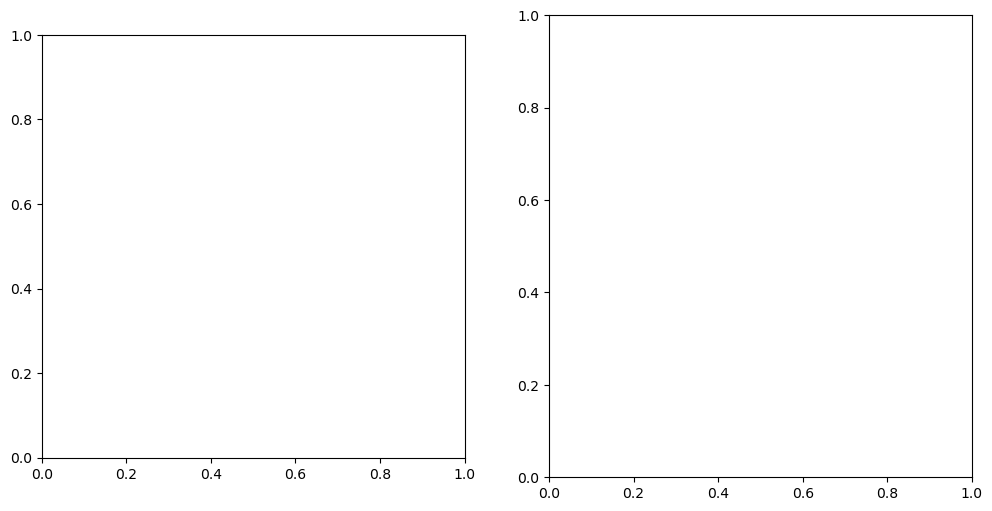

In [60]:
plot_image_and_mask(img_ids[0], mascara, category_info_objetive)

In [64]:
plot_one_hot_encoded_masks(img, mascara, category_info_objetive, coco, DIR_TRAIN_IMGS)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\ruben\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ruben\AppData\Local\Temp\ipykernel_60472\1697259899.py", line 1, in <module>
    plot_one_hot_encoded_masks(img, mascara, category_info_objetive, coco, DIR_TRAIN_IMGS)
  File "c:\Users\ruben\Desktop\code_tfm\src\utils.py", line 337, in plot_one_hot_encoded_masks
    plot_image_with_masks(image_id, masks, categories_ids, coco, images_path)
  File "c:\Users\ruben\Desktop\code_tfm\src\utils.py", line 272, in plot_image_with_masks
    # def plot_image_with_masks(image_id, masks, categories_ids, coco, images_path):
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: 'NoneType' object is not subscriptable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\ruben\anaconda3\Lib\site-packages\IPython\core\in

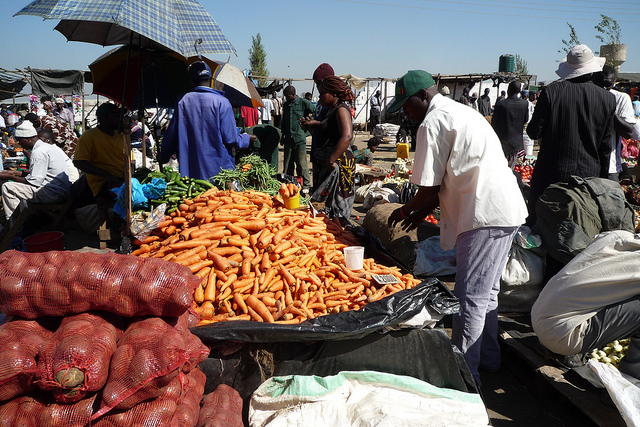

In [67]:
img

In [69]:
img_ids = coco.getImgIds()
img_info = coco.loadImgs(img_ids[0])[0]
img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"

image = Image.open(img_path).convert("RGB")

transform = T.Compose([
    T.ToTensor()
])
img_tensor = transform(image).unsqueeze(0)

In [71]:
import torchvision
import torch

model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)


In [73]:
model.eval()
with torch.no_grad():
    outputs = model(img_tensor)

In [75]:
outputs

[{'boxes': tensor([[345.1577,  29.6931, 484.8401, 326.2527],
          [349.5066, 128.0932, 478.5281, 350.7043],
          [471.3108, 173.0810, 503.5979, 222.3501],
          [485.2825, 184.1756, 514.6503, 220.1679],
          [481.6461, 179.9488, 514.0982, 220.9052],
          [487.0061, 186.1782, 514.4231, 220.6229],
          [473.6937, 177.2653, 509.8673, 221.6790],
          [383.6362, 140.8949, 449.4614, 200.6486],
          [473.6937, 177.2653, 509.8673, 221.6790],
          [383.6362, 140.8949, 449.4614, 200.6486],
          [435.5513, 134.8892, 497.8256, 323.0955],
          [498.4421, 175.9713, 519.3246, 193.3845],
          [346.2180,  93.4656, 424.0574, 279.2641],
          [380.5142, 127.5561, 464.0667, 236.7812],
          [487.0061, 186.1782, 514.4231, 220.6229],
          [ 64.6833, 144.4415,  69.5093, 148.9254],
          [486.8379, 178.0426, 515.8809, 201.0156],
          [473.6937, 177.2653, 509.8673, 221.6790],
          [442.6719, 155.5842, 476.3090, 224.7606],
   

In [89]:
color_map = {cls: plt.cm.get_cmap('tab10')(i) for i, cls in enumerate(id_objetives)}

C:\Users\ruben\AppData\Local\Temp\ipykernel_60472\3958937070.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = {cls: plt.cm.get_cmap('tab10')(i) for i, cls in enumerate(id_objetives)}


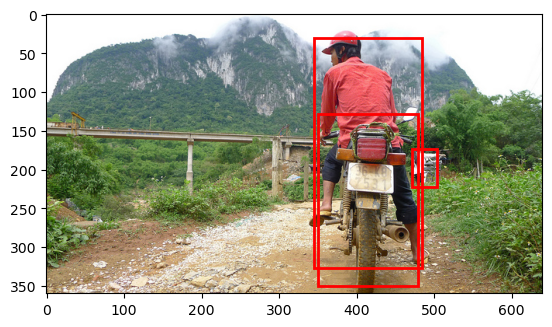

In [74]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1)
ax.imshow(image)

for box, score, label in zip(outputs[0]['boxes'], outputs[0]['scores'], outputs[0]['labels']):
    if score > 0.5:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
plt.show()


In [81]:
outputs[0]['labels'].unique()

tensor([ 1,  2,  3,  4,  7, 15, 27, 31, 33, 41, 62, 64, 67, 77, 81, 85, 87, 89])

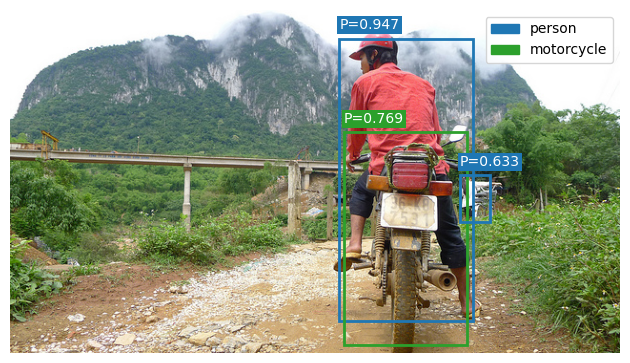

In [102]:
fig, ax = plt.subplots()
ax.imshow(image)

# Draw boxes with labels
classess_found = []
for box, score, label in zip(outputs[0]['boxes'], outputs[0]['scores'], outputs[0]['labels']):
    if(label in id_objetives and score > CONS_TRHESHOLD):
        x_min, y_min, x_max, y_max = box
        width, height = x_max - x_min, y_max - y_min
        color = color_map[label.item()]
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2,
                                edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min - 10, f"P="+str(round(score.item(), 3)), color='white', fontsize=10,bbox=dict(facecolor=color, edgecolor='none', pad=1.5))
        classess_found.append(label)

# Create legend
handles = [patches.Patch(color=color_map[cls], label=category_info_id[cls]) for cls in id_objetives if cls in classess_found]
ax.legend(handles=handles, loc='upper right')

plt.axis('off')
plt.tight_layout()
plt.show()